# Tidied up version of the predictive model

- [ACF, PCAF and stationarity](#acf_pacf)
- [Testing some models by the ACF and PACF analysis (AIC score)](#testing_models_1)
- [Best SARIMA model and test set comparison](#plot_best_sarima)
- [Best SARIMA model and test set comparison after walking-forward validation](#walk_forward_val)
- [Anomalies Identification in the timeseries](#anomaly_identification)
    - [A quantitative approach](#quantitative_approach)
    - [Spotting the anomalies within 3$\sigma$](#spotting_3sigma)
- [A new dataset: correcting the anomaly points](#new_dataset)
- [The new prediction](#new_prediction)
- [RMSE comparison between the old and the corrected data training sets](#rmse_comparison)
- [Preparing the dataset for the XGBoost prediction](#xgb)
- [SARIMA-XGBoost comparison](#sarima-xgb-comparison)
- [Trying to create some features to look for improvements](#xgb_feature)

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import statsmodels.api as sm
import scipy as sp
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from datetime import datetime

from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

import seaborn as sns
sns.set_theme(style="darkgrid")

<a id='acf_pacf'></a>
## Checking ACF, PCAF and the stationarity

Here we analyze the ACF and the PCAF for the identification
of the SARIMA model's parameter. We also investigate the stationarity
by the Augmented Dicker Fuller test. We do the latter for the dataset
itself, its first difference and its seasonal difference.

In [216]:
df2014 = pd.read_csv('datasets/df2014.csv', index_col = 'datahora', parse_dates = True, usecols = ['datahora', 'riscofogo'])
df2015 = pd.read_csv('datasets/df2015.csv', index_col = 'datahora', parse_dates = True, usecols = ['datahora', 'riscofogo'])
df2016 = pd.read_csv('datasets/df2016.csv', index_col = 'datahora', parse_dates = True, usecols = ['datahora', 'riscofogo'])
df2017 = pd.read_csv('datasets/df2017.csv', index_col = 'datahora', parse_dates = True, usecols = ['datahora', 'riscofogo'])
df2018 = pd.read_csv('datasets/df2018.csv', index_col = 'datahora', parse_dates = True, usecols = ['datahora', 'riscofogo'])
#df2019 = pd.read_csv('datasets/df2019.csv', index_col = 'datahora', parse_dates = True, usecols = ['datahora', 'riscofogo'])
#df2020 = pd.read_csv('datasets/df2020.csv', index_col = 'datahora', parse_dates = True, usecols = ['datahora', 'riscofogo'])

In [536]:
df_all = pd.concat([df2014, df2015, df2016, df2017, df2018]).sort_index()
df_all = df_all[df_all.riscofogo == 1]

df_all = df_all.resample('SM').sum()

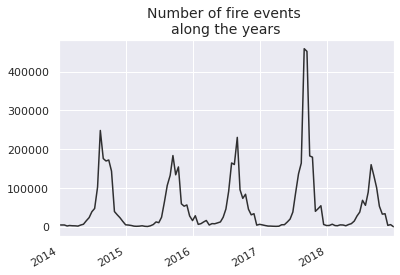

In [537]:
fig, ax = plt.subplots()

ax.plot(df_all, c = 'black', alpha = 0.8)
ax.set_title('Number of fire events \nalong the years', fontsize = 14)
ax.set_xlim(df_all.index[0], df_all.index[-1])

plt.gcf().autofmt_xdate()
plt.show()

We can clearly see a seasonal component in the timeseries.
Let's analyse it better to also investigate its trend as well
by making a seasonal, trend decomposition.

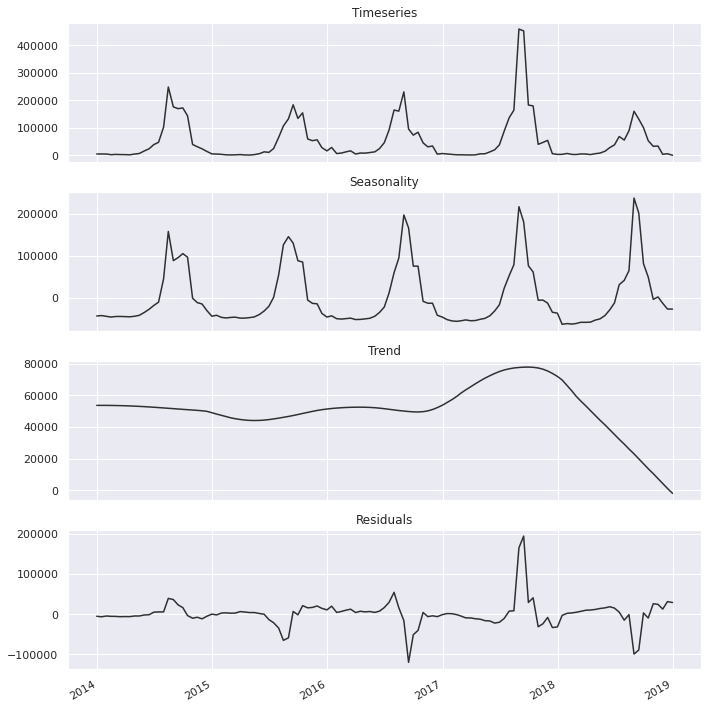

In [538]:
stl = STL(df_all, period = 24) ## Semi-month data
decomposition = stl.fit()

seasonal, trend, residuals = decomposition.seasonal, decomposition.trend, decomposition.resid

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize = (10, 10))

ax1.plot(df_all, c = 'black', alpha = 0.8)
ax1.set_title('Timeseries')
ax2.plot(seasonal, c = 'black', alpha = 0.8)
ax2.set_title('Seasonality')
ax3.plot(trend, c = 'black', alpha = 0.8)
ax3.set_title('Trend')
ax4.plot(residuals, c = 'black', alpha = 0.8)
ax4.set_title('Residuals')
plt.gcf().autofmt_xdate()


plt.tight_layout()
plt.show()

In the timeseries we observer already a seasonality and the stl decomposition
highlights it even more. We observe the trend of the timeseris and clearly
see that there was an increament in 2017 and it had a very steep descend in 2018.
It helps us in seeing that there might be some issues related to anomaly to be solved.

Despite of already having a clue to what will be necessary to be done,
the ACF and PACF might give us some clue of further needed steps.

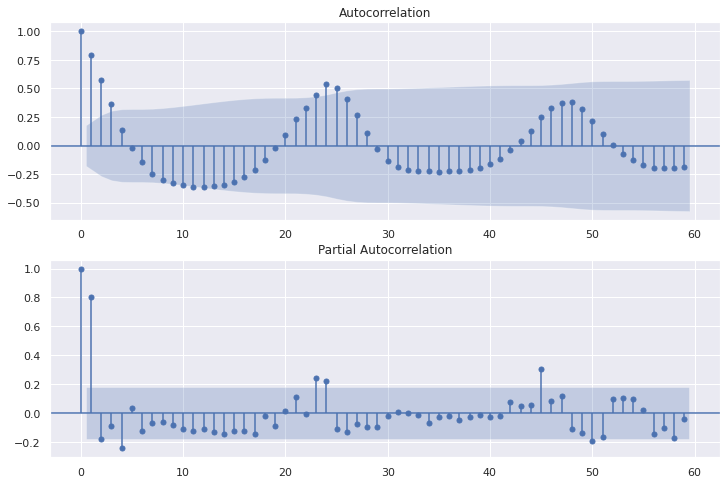

In [539]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 8))

plot_acf(df_all.dropna(),lags=59,ax=ax1)
plot_pacf(df_all.dropna(),lags=59,ax=ax2)
plt.show()

We observe that PACF shuts off heavily after the first lag. It shows some other relevant lags
which might be interesting taking a closer look, lags two and three. However, there are other
few quasi-relevant lags. So, it is not that good the way that it is. When we take a closer
look at the ACF it becomes even clearer! The ACF has an extremely slow decay and oscillatory
decay. It is signature that we need to make a differencing to shut this off faster.

/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


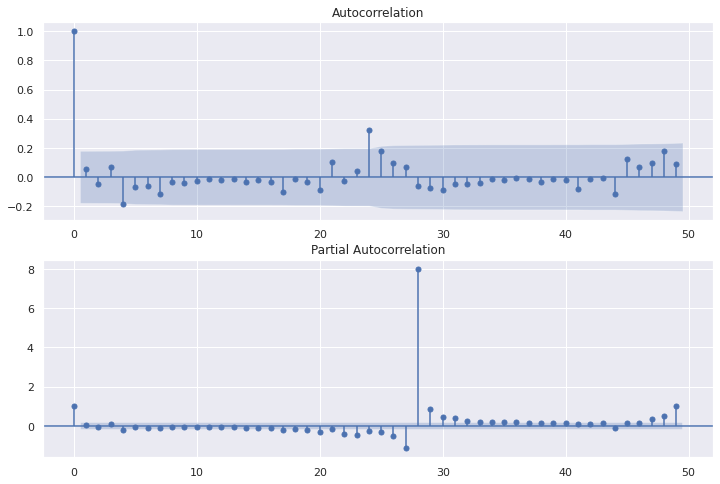

In [540]:
diff_1st = (df_all - df_all.shift(1)).dropna()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 8))

plot_acf(diff_1st.dropna(),lags=49,ax=ax1)
plot_pacf(diff_1st.dropna(),lags=49,ax=ax2)

plt.show()

So it indeed helped, as expected. Let's make a seasonal difference now and see how it behaves.

/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


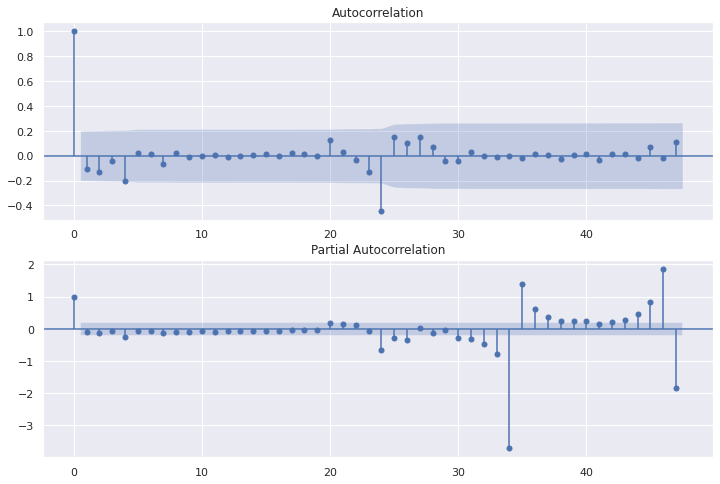

In [541]:
diff_seas_plus_1st = (diff_1st - diff_1st.shift(24)).dropna()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 8))

plot_acf(diff_seas_plus_1st.dropna(),lags=47,ax=ax1)
plot_pacf(diff_seas_plus_1st.dropna(),lags=47,ax=ax2)

plt.show()

Nice! It indeed solved most of the issues. We can observe a weird behavior within the
large lagged values, which might be something to investigate or not. But let's do that
later (if indeed needed it). We made a first and a seasonal difference, consequently we have

$$d = D = 1$$

Regarding the non-seasonal part, we observe that the first relevant lag is $p = 4$ and
$q = 4$ . So, it might be interesting investigating all the prior lags, since some
of them are quasi-relevant lags. Therefore we have

$$p = (0, 4)\\
q = (0, 4)$$

To what concerns the seasonal part, the ACF shows a relevant lag for $Q = 1$, it could
also be interesting testing $Q = 2$. PACF, on the other hand, shows the weird behavior
for higher lags, which might be some statistical fluctuation or indeed a relevant lag,
which needs to be investigate, thus we have

$$P = (1, 2)\\
Q = (1, 2)$$

In [542]:
#Testing the stationarity for the seasonal difference

stationary_test = adfuller(diff_seas_plus_1st.riscofogo.dropna())

print('ADF statistics : {}'.format(stationary_test[0]))
print('p-value : {}'.format(stationary_test[1]))

## So it is indeed stationary

ADF statistics : -6.9077818868735745
p-value : 1.2344864528171193e-09


<a id='testing_models_1'></a>

## Testing some models

Here we test some models playing with the autoregressive, moving average
and differencing part (using the above ACF and PCAF plots as reference).
We use the Akaike test for investigating the better model, since it
takes into consideration the prediction itself and also the number of
parameters, being a balance between over- and underfitting.

In [ ]:
def model_sarima(order, sorder):
    sarima_model = sm.tsa.statespace.SARIMAX(df_all, order = order,
                                            seasonal_order = sorder,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
    res = sarima_model.fit()
    
    return order, sorder, res.aic

In [241]:
dict_model = dict()
#d = D = 1 p = (0, 4) q = (0, 4) P = (1, 2) Q = (1, 2)
for q in range (0, 5):
    for p in range (0, 5):
        for d in range (0, 2): # Let's try some differences and see how it affects the model
            for Q in range (0, 3):
                    for P in range (1, 3):
                        order = (p, 1, q)
                        sorder = (P, 1, Q, 24)
                        model = model_sarima(order, sorder)
                        print('Model : {} X {}; AIC : {}'.format(order, sorder, model[2]))
                        dict_model[model[2]] = (order, sorder)
                    
                        #model = model_sarima((p, d, q), (P, 1, Q, 52))
                        #print('Model : {} X {}; AIC : {}'.format(model1[0], model1[1], model1[2]))

Model : (0, 1, 0) X (1, 1, 0, 24); AIC : 1776.7962586514009
Model : (0, 1, 0) X (2, 1, 0, 24); AIC : 1190.4236017374305


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (0, 1, 0) X (1, 1, 1, 24); AIC : 2428.0943002730937


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (0, 1, 0) X (2, 1, 1, 24); AIC : 1824.5755878478847


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Model : (0, 1, 0) X (1, 1, 2, 24); AIC : 1168.4789476284143
Model : (0, 1, 0) X (2, 1, 2, 24); AIC : 1170.0349434874606
Model : (0, 1, 0) X (1, 1, 0, 24); AIC : 1776.7962586514009
Model : (0, 1, 0) X (2, 1, 0, 24); AIC : 1190.4236017374305


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (0, 1, 0) X (1, 1, 1, 24); AIC : 2428.0943002730937


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (0, 1, 0) X (2, 1, 1, 24); AIC : 1824.5755878478847
Model : (0, 1, 0) X (1, 1, 2, 24); AIC : 1168.4789476284143
Model : (0, 1, 0) X (2, 1, 2, 24); AIC : 1170.0349434874606
Model : (1, 1, 0) X (1, 1, 0, 24); AIC : 1754.9706479478155
Model : (1, 1, 0) X (2, 1, 0, 24); AIC : 1169.276405652298
Model : (1, 1, 0) X (1, 1, 1, 24); AIC : 5797.168984601749
Model : (1, 1, 0) X (2, 1, 1, 24); AIC : 3992.4562327134936
Model : (1, 1, 0) X (1, 1, 2, 24); AIC : 1169.931064452017
Model : (1, 1, 0) X (2, 1, 2, 24); AIC : 1170.906390452128
Model : (1, 1, 0) X (1, 1, 0, 24); AIC : 1754.9706479478155
Model : (1, 1, 0) X (2, 1, 0, 24); AIC : 1169.276405652298
Model : (1, 1, 0) X (1, 1, 1, 24); AIC : 5797.168984601749
Model : (1, 1, 0) X (2, 1, 1, 24); AIC : 3992.4562327134936
Model : (1, 1, 0) X (1, 1, 2, 24); AIC : 1169.931064452017
Model : (1, 1, 0) X (2, 1, 2, 24); AIC : 1170.906390452128
Model : (2, 1, 0) X (1, 1, 0, 24); AIC : 1730.66946572083
Model : (2, 1, 0) X (2, 1, 0, 24); AIC : 1144.4747

Model : (2, 1, 2) X (2, 1, 1, 24); AIC : 3914.067324233222
Model : (2, 1, 2) X (1, 1, 2, 24); AIC : 1120.3953916167084


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 1, 2) X (2, 1, 2, 24); AIC : 1117.376379614818
Model : (2, 1, 2) X (1, 1, 0, 24); AIC : 1727.652530154765
Model : (2, 1, 2) X (2, 1, 0, 24); AIC : 1142.3852138993573
Model : (2, 1, 2) X (1, 1, 1, 24); AIC : 5640.610106218002
Model : (2, 1, 2) X (2, 1, 1, 24); AIC : 3914.067324233222
Model : (2, 1, 2) X (1, 1, 2, 24); AIC : 1120.3953916167084


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 1, 2) X (2, 1, 2, 24); AIC : 1117.376379614818
Model : (3, 1, 2) X (1, 1, 0, 24); AIC : 1705.7361107369695
Model : (3, 1, 2) X (2, 1, 0, 24); AIC : 1119.8749141734274
Model : (3, 1, 2) X (1, 1, 1, 24); AIC : 5642.592688453861
Model : (3, 1, 2) X (2, 1, 1, 24); AIC : 3831.315370816756
Model : (3, 1, 2) X (1, 1, 2, 24); AIC : 1121.935809027985


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 1, 2) X (2, 1, 2, 24); AIC : 1118.8789451001912
Model : (3, 1, 2) X (1, 1, 0, 24); AIC : 1705.7361107369695
Model : (3, 1, 2) X (2, 1, 0, 24); AIC : 1119.8749141734274
Model : (3, 1, 2) X (1, 1, 1, 24); AIC : 5642.592688453861
Model : (3, 1, 2) X (2, 1, 1, 24); AIC : 3831.315370816756
Model : (3, 1, 2) X (1, 1, 2, 24); AIC : 1121.935809027985


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 1, 2) X (2, 1, 2, 24); AIC : 1118.8789451001912
Model : (4, 1, 2) X (1, 1, 0, 24); AIC : 1683.121947157068
Model : (4, 1, 2) X (2, 1, 0, 24); AIC : 1097.2646706377186
Model : (4, 1, 2) X (1, 1, 1, 24); AIC : 5561.027855858166
Model : (4, 1, 2) X (2, 1, 1, 24); AIC : 3747.267963286409
Model : (4, 1, 2) X (1, 1, 2, 24); AIC : 1123.2379668409171


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 1, 2) X (2, 1, 2, 24); AIC : 1096.0020247823063
Model : (4, 1, 2) X (1, 1, 0, 24); AIC : 1683.121947157068
Model : (4, 1, 2) X (2, 1, 0, 24); AIC : 1097.2646706377186
Model : (4, 1, 2) X (1, 1, 1, 24); AIC : 5561.027855858166
Model : (4, 1, 2) X (2, 1, 1, 24); AIC : 3747.267963286409
Model : (4, 1, 2) X (1, 1, 2, 24); AIC : 1123.2379668409171


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 1, 2) X (2, 1, 2, 24); AIC : 1096.0020247823063
Model : (0, 1, 3) X (1, 1, 0, 24); AIC : 1776.8234021005483
Model : (0, 1, 3) X (2, 1, 0, 24); AIC : 1190.7468066211864
Model : (0, 1, 3) X (1, 1, 1, 24); AIC : 5560.084257027963
Model : (0, 1, 3) X (2, 1, 1, 24); AIC : 4083.6797297585063
Model : (0, 1, 3) X (1, 1, 2, 24); AIC : 1094.1267963559035


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (0, 1, 3) X (2, 1, 2, 24); AIC : 1093.1691434179097
Model : (0, 1, 3) X (1, 1, 0, 24); AIC : 1776.8234021005483
Model : (0, 1, 3) X (2, 1, 0, 24); AIC : 1190.7468066211864
Model : (0, 1, 3) X (1, 1, 1, 24); AIC : 5560.084257027963
Model : (0, 1, 3) X (2, 1, 1, 24); AIC : 4083.6797297585063
Model : (0, 1, 3) X (1, 1, 2, 24); AIC : 1094.1267963559035


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (0, 1, 3) X (2, 1, 2, 24); AIC : 1093.1691434179097
Model : (1, 1, 3) X (1, 1, 0, 24); AIC : 1753.1256489394848
Model : (1, 1, 3) X (2, 1, 0, 24); AIC : 1167.5170800051108
Model : (1, 1, 3) X (1, 1, 1, 24); AIC : 5561.958510411838
Model : (1, 1, 3) X (2, 1, 1, 24); AIC : 4000.8078222862164


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 1, 3) X (1, 1, 2, 24); AIC : 1095.4179922789147


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 1, 3) X (2, 1, 2, 24); AIC : 1094.5687682764517
Model : (1, 1, 3) X (1, 1, 0, 24); AIC : 1753.1256489394848
Model : (1, 1, 3) X (2, 1, 0, 24); AIC : 1167.5170800051108
Model : (1, 1, 3) X (1, 1, 1, 24); AIC : 5561.958510411838
Model : (1, 1, 3) X (2, 1, 1, 24); AIC : 4000.8078222862164


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 1, 3) X (1, 1, 2, 24); AIC : 1095.4179922789147


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 1, 3) X (2, 1, 2, 24); AIC : 1094.5687682764517
Model : (2, 1, 3) X (1, 1, 0, 24); AIC : 1730.2910721093792
Model : (2, 1, 3) X (2, 1, 0, 24); AIC : 1144.6454406315197
Model : (2, 1, 3) X (1, 1, 1, 24); AIC : 5562.805530991706
Model : (2, 1, 3) X (2, 1, 1, 24); AIC : 3917.2447204646314
Model : (2, 1, 3) X (1, 1, 2, 24); AIC : 1098.7451883935798


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 1, 3) X (2, 1, 2, 24); AIC : 1096.359822376258
Model : (2, 1, 3) X (1, 1, 0, 24); AIC : 1730.2910721093792
Model : (2, 1, 3) X (2, 1, 0, 24); AIC : 1144.6454406315197
Model : (2, 1, 3) X (1, 1, 1, 24); AIC : 5562.805530991706
Model : (2, 1, 3) X (2, 1, 1, 24); AIC : 3917.2447204646314
Model : (2, 1, 3) X (1, 1, 2, 24); AIC : 1098.7451883935798


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 1, 3) X (2, 1, 2, 24); AIC : 1096.359822376258
Model : (3, 1, 3) X (1, 1, 0, 24); AIC : 1706.8393267095782


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 1, 3) X (2, 1, 0, 24); AIC : 1122.3810391121576
Model : (3, 1, 3) X (1, 1, 1, 24); AIC : 5562.820289489344
Model : (3, 1, 3) X (2, 1, 1, 24); AIC : 3833.1647681303925


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 1, 3) X (1, 1, 2, 24); AIC : 1096.1670619645358


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 1, 3) X (2, 1, 2, 24); AIC : 1098.1249840023218
Model : (3, 1, 3) X (1, 1, 0, 24); AIC : 1706.8393267095782


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 1, 3) X (2, 1, 0, 24); AIC : 1122.3810391121576
Model : (3, 1, 3) X (1, 1, 1, 24); AIC : 5562.820289489344
Model : (3, 1, 3) X (2, 1, 1, 24); AIC : 3833.1647681303925


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 1, 3) X (1, 1, 2, 24); AIC : 1096.1670619645358


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 1, 3) X (2, 1, 2, 24); AIC : 1098.1249840023218


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 1, 3) X (1, 1, 0, 24); AIC : 1684.4178869934315
Model : (4, 1, 3) X (2, 1, 0, 24); AIC : 1097.5742334656802
Model : (4, 1, 3) X (1, 1, 1, 24); AIC : 5563.260554233297
Model : (4, 1, 3) X (2, 1, 1, 24); AIC : 3749.41853282326


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 1, 3) X (1, 1, 2, 24); AIC : 1097.2970772146398


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 1, 3) X (2, 1, 2, 24); AIC : 1098.7480109508097


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 1, 3) X (1, 1, 0, 24); AIC : 1684.4178869934315
Model : (4, 1, 3) X (2, 1, 0, 24); AIC : 1097.5742334656802
Model : (4, 1, 3) X (1, 1, 1, 24); AIC : 5563.260554233297
Model : (4, 1, 3) X (2, 1, 1, 24); AIC : 3749.41853282326


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 1, 3) X (1, 1, 2, 24); AIC : 1097.2970772146398


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 1, 3) X (2, 1, 2, 24); AIC : 1098.7480109508097
Model : (0, 1, 4) X (1, 1, 0, 24); AIC : 1774.439548211851
Model : (0, 1, 4) X (2, 1, 0, 24); AIC : 1189.826590941535
Model : (0, 1, 4) X (1, 1, 1, 24); AIC : 5474.53563537578
Model : (0, 1, 4) X (2, 1, 1, 24); AIC : 4081.4104899131626
Model : (0, 1, 4) X (1, 1, 2, 24); AIC : 1071.9955156479025


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (0, 1, 4) X (2, 1, 2, 24); AIC : 1069.9629354807932
Model : (0, 1, 4) X (1, 1, 0, 24); AIC : 1774.439548211851
Model : (0, 1, 4) X (2, 1, 0, 24); AIC : 1189.826590941535
Model : (0, 1, 4) X (1, 1, 1, 24); AIC : 5474.53563537578
Model : (0, 1, 4) X (2, 1, 1, 24); AIC : 4081.4104899131626
Model : (0, 1, 4) X (1, 1, 2, 24); AIC : 1071.9955156479025


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (0, 1, 4) X (2, 1, 2, 24); AIC : 1069.9629354807932
Model : (1, 1, 4) X (1, 1, 0, 24); AIC : 1752.3069294163959
Model : (1, 1, 4) X (2, 1, 0, 24); AIC : 1167.379436898121
Model : (1, 1, 4) X (1, 1, 1, 24); AIC : 5476.500353597824
Model : (1, 1, 4) X (2, 1, 1, 24); AIC : 3998.689688136033
Model : (1, 1, 4) X (1, 1, 2, 24); AIC : 1073.704825062164


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 1, 4) X (2, 1, 2, 24); AIC : 1074.6891130797012
Model : (1, 1, 4) X (1, 1, 0, 24); AIC : 1752.3069294163959
Model : (1, 1, 4) X (2, 1, 0, 24); AIC : 1167.379436898121
Model : (1, 1, 4) X (1, 1, 1, 24); AIC : 5476.500353597824
Model : (1, 1, 4) X (2, 1, 1, 24); AIC : 3998.689688136033
Model : (1, 1, 4) X (1, 1, 2, 24); AIC : 1073.704825062164


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 1, 4) X (2, 1, 2, 24); AIC : 1074.6891130797012
Model : (2, 1, 4) X (1, 1, 0, 24); AIC : 1730.4166975162059


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 1, 4) X (2, 1, 0, 24); AIC : 1145.4413097799984
Model : (2, 1, 4) X (1, 1, 1, 24); AIC : 5478.50035918167
Model : (2, 1, 4) X (2, 1, 1, 24); AIC : 3915.99416669023


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 1, 4) X (1, 1, 2, 24); AIC : 1074.2697662549426


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 1, 4) X (2, 1, 2, 24); AIC : 1073.3269214529132
Model : (2, 1, 4) X (1, 1, 0, 24); AIC : 1730.4166975162059


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 1, 4) X (2, 1, 0, 24); AIC : 1145.4413097799984
Model : (2, 1, 4) X (1, 1, 1, 24); AIC : 5478.50035918167
Model : (2, 1, 4) X (2, 1, 1, 24); AIC : 3915.99416669023


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 1, 4) X (1, 1, 2, 24); AIC : 1074.2697662549426


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 1, 4) X (2, 1, 2, 24); AIC : 1073.3269214529132


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 1, 4) X (1, 1, 0, 24); AIC : 1707.6950535343228


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 1, 4) X (2, 1, 0, 24); AIC : 1119.6626962335192
Model : (3, 1, 4) X (1, 1, 1, 24); AIC : 5479.887429086724
Model : (3, 1, 4) X (2, 1, 1, 24); AIC : 3832.8869718606416


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 1, 4) X (1, 1, 2, 24); AIC : 1073.374853576965


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 1, 4) X (2, 1, 2, 24); AIC : 1074.7647363999163


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 1, 4) X (1, 1, 0, 24); AIC : 1707.6950535343228


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 1, 4) X (2, 1, 0, 24); AIC : 1119.6626962335192
Model : (3, 1, 4) X (1, 1, 1, 24); AIC : 5479.887429086724
Model : (3, 1, 4) X (2, 1, 1, 24); AIC : 3832.8869718606416


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 1, 4) X (1, 1, 2, 24); AIC : 1073.374853576965


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (3, 1, 4) X (2, 1, 2, 24); AIC : 1074.7647363999163


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 1, 4) X (1, 1, 0, 24); AIC : 1685.776619807426


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 1, 4) X (2, 1, 0, 24); AIC : 1097.1045371643336
Model : (4, 1, 4) X (1, 1, 1, 24); AIC : 5481.877134851285
Model : (4, 1, 4) X (2, 1, 1, 24); AIC : 3750.1938343147604


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 1, 4) X (1, 1, 2, 24); AIC : 1074.8260368074802


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 1, 4) X (2, 1, 2, 24); AIC : 1076.6148971828595


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 1, 4) X (1, 1, 0, 24); AIC : 1685.776619807426


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 1, 4) X (2, 1, 0, 24); AIC : 1097.1045371643336
Model : (4, 1, 4) X (1, 1, 1, 24); AIC : 5481.877134851285
Model : (4, 1, 4) X (2, 1, 1, 24); AIC : 3750.1938343147604


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 1, 4) X (1, 1, 2, 24); AIC : 1074.8260368074802


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (4, 1, 4) X (2, 1, 2, 24); AIC : 1076.6148971828595


In [424]:
### Getting best sarima models

for score in dict_model:
    if 1000 <= score < 1080:
        print(dict_model[score], score)

((0, 1, 4), (1, 1, 2, 24)) 1071.9955156479025
((0, 1, 4), (2, 1, 2, 24)) 1069.9629354807932
((1, 1, 4), (1, 1, 2, 24)) 1073.704825062164
((1, 1, 4), (2, 1, 2, 24)) 1074.6891130797012
((2, 1, 4), (1, 1, 2, 24)) 1074.2697662549426
((2, 1, 4), (2, 1, 2, 24)) 1073.3269214529132
((3, 1, 4), (1, 1, 2, 24)) 1073.374853576965
((3, 1, 4), (2, 1, 2, 24)) 1074.7647363999163
((4, 1, 4), (1, 1, 2, 24)) 1074.8260368074802
((4, 1, 4), (2, 1, 2, 24)) 1076.6148971828595


<a id='plot_best_sarima'></a>
## Ploting the best SARIMA model
After looping through several models, we plot one
of the best and compare with the dataset

In [544]:
y_train = df_all[:len(df_all) - 24]
y_test = df_all[len(df_all) - 24:]

order = (3, 1, 2)
sorder = (2, 1, 0, 24)

sarima_model = sm.tsa.statespace.SARIMAX(y_train.riscofogo, order = order,
                                         seasonal_order = sorder,
                                         enforce_stationarity=False,
                                         enforce_invertibility=False)

res = sarima_model.fit()
forecast = res.get_forecast(len(y_test))

The model above is the first to not present any error nor warning concerning
likelihood conversion.Therefore we stick with it.

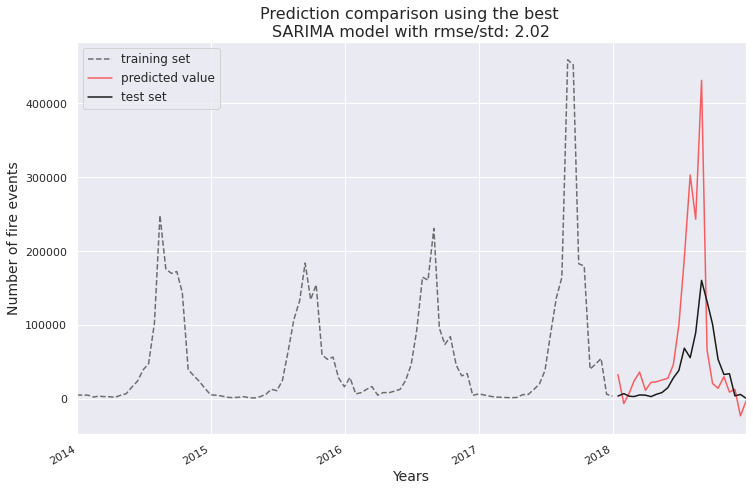

In [545]:
fig, ax = plt.subplots(figsize = (12, 8))

## Calculating the rmse and std for comparison
rmse = np.sqrt(mean_squared_error(forecast.predicted_mean, y_test.riscofogo))
std = y_test.riscofogo.std()
comparison = round(rmse/std, 2)

#print (rmse)
#print (std)

predictions = forecast.predicted_mean
ax.plot(y_train.riscofogo, label = 'training set', color = 'k', alpha = 0.6, linestyle = '--')
ax.plot(predictions, label = 'predicted value', color = 'red', alpha = 0.6)
ax.plot(y_test.riscofogo, label = 'test set', color = 'k')

ax.set_title('Prediction comparison using the best \nSARIMA model with rmse/std: {}'.format(comparison),
             fontsize = 16)
ax.set_xlabel('Years', fontsize = 14)
ax.set_ylabel('Number of fire events', fontsize = 14)
ax.set_xlim(y_train.index[0], y_test.index[-1])

plt.gcf().autofmt_xdate()

plt.legend(fontsize = 12)
plt.show()

### Metric to be used and discussion

So we observe that our SARIMA model is not performing too well in predicting it. A simple
mean value model is making a better job than our model, that can be seen by the RMSE/STD
comparison (if our model was doing a better job, it would be a number smaller than one).

1) Graphically it is easy to see why is that so. Firstly, the peak is **much** bigger
than the real one. As we have pointed out previously, that is easy to be understood,
since we have anomalies in the dataset (being the one in 2017 the most evident). Also,
graphically-wise, we observe that our dataset has an offset which shifts the entire
dataset by a positive amount. Handling the anomaly might solve these issues.

2) Secondly, we are trying to make a prediction too much in advance. It is well-known
that in timeseries we must have "different time-scales" for prediction. Another option which
might help us in this task is performing a walk-forward validation (also known as rolling
forecasting technique). The latter consists is being "less greedy" and performing a
forecasting for one month in advance (for example) instead of one entire year.

3) Since we are dealing with anomalies, we are going to use squared error rather
than absolute value.

<a id='anomaly_identification'></a>
## Identifying the anomaly(ies) and handling it(them)

<a id='quantitative_approach'></a>

## The seasonal, trend decomposition

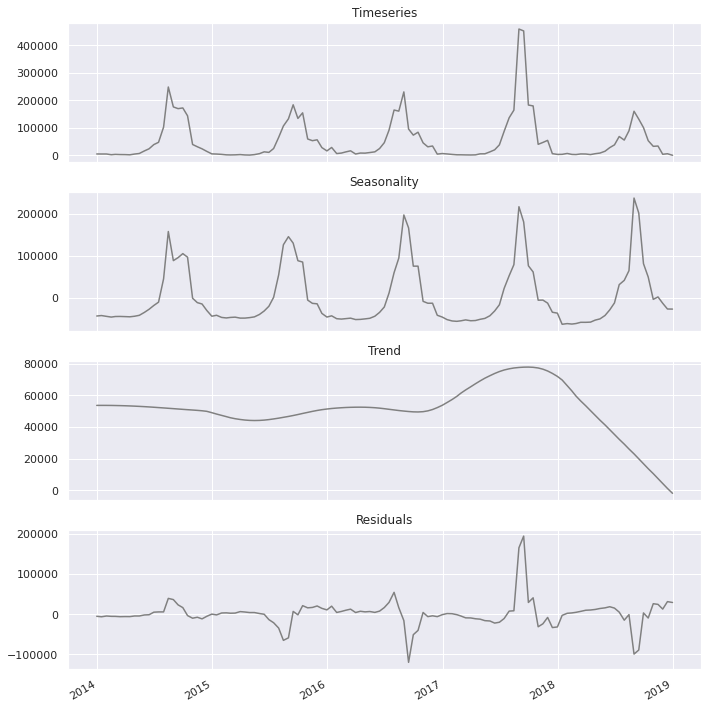

In [546]:
## seasonal trend decomposition 

stl = STL(df_all, period = 24) ## Since we have a semimonth data
decomposition = stl.fit()

seasonal, trend, residuals = decomposition.seasonal, decomposition.trend, decomposition.resid

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize = (10, 10))

ax1.plot(df_all, c = 'grey')
ax1.set_title('Timeseries')
ax2.plot(seasonal, c = 'grey')
ax2.set_title('Seasonality')
ax3.plot(trend, c = 'grey')
ax3.set_title('Trend')
ax4.plot(residuals, c = 'grey')
ax4.set_title('Residuals')

plt.gcf().autofmt_xdate()


plt.tight_layout()
plt.show()

In the ideal world, the timeseries can be cast in terms of its seasonality and its trend.
However, we have the residuals, which is the timeseries after discounting the seasonality
and the trend of it. A way of spoting anomalies is investigating the residuals
of the timeseries, when the residual is too big, we can infer that there are anomalies
happening.

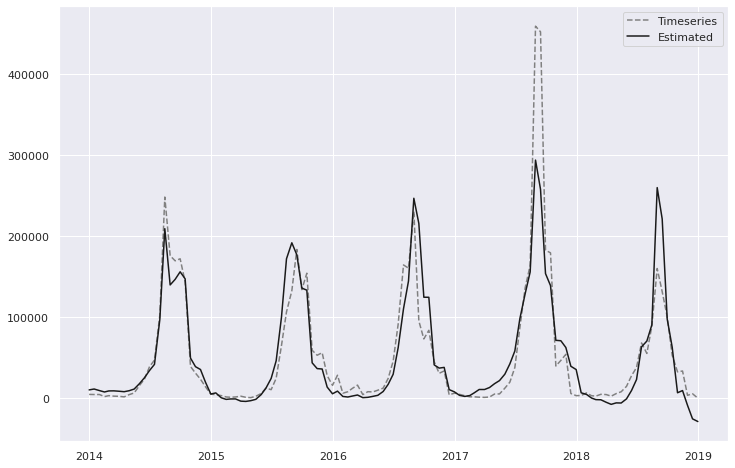

In [547]:
## Getting the difference due to the residuals

plt.figure(figsize = (12,8))
plt.plot(df_all, label = 'Timeseries', c = 'grey', linestyle = '--')
plt.plot(seasonal+trend, label = "Estimated", c = 'k')
plt.legend()
plt.show()

<a id='spotting_3sigma'></a>

## Brief discussion about the above result

By the above result, we observe that the difference between the estimated curve and
the real timeseries is entirely due to the residuals. What is left for us is to decide
whether these residuals are anomalies or not. For example, for sure in 2017 there is an
anomaly event, as discussed previously. Now what we want is to analyze other mismatches,
for example, like the one in 2014 and 2016. *are those anomalies as well?* To  do so,
we need to quantify it better. Let's then analyze the residuals in greater detail

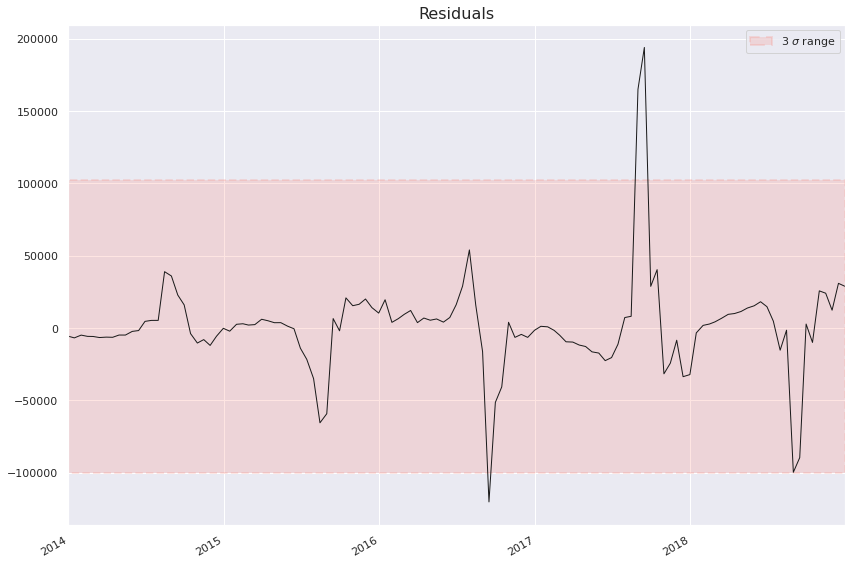

In [548]:
# Working with  the residuals

residuals_mean = residuals.mean()
residuals_std = residuals.std()

## Getting the lower and upper values of it, we are going to use 3 std

lower = residuals_mean - 3*residuals_std
upper = residuals_mean + 3*residuals_std

fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(residuals, color = 'k', linewidth = 1)

ax.fill_between([df_all.index[0], df_all.index[-1]], lower, upper,
                label = '3 $\sigma$ range',
                color = 'salmon', alpha = 0.2,
                linestyle = '--', linewidth = 2)

ax.set_xlim(df_all.index[0], df_all.index[-1])

ax.set_title('Residuals', fontsize = 16)

ax.set_xlim(y_train.index[0], y_test.index[-1])

plt.gcf().autofmt_xdate()

plt.legend()
plt.tight_layout()
plt.show()

Everything that is out of the bar is considered anomaly within 95% confidence level.
We observe that we have an anomaly event during 2016 and the clear one in 2017.
Interestingly, the events during 2018 are almost anomalies. However,
this is our testing set and won't be change.

In [549]:
## Getting the anomalie points and to show them into the plot

anomaly_dates = df_all[(residuals > upper) | (residuals < lower)]

anomaly_dates

,riscofogo
datahora,
2016-09-15,95478.0
2017-08-31,458846.0
2017-09-15,451911.0


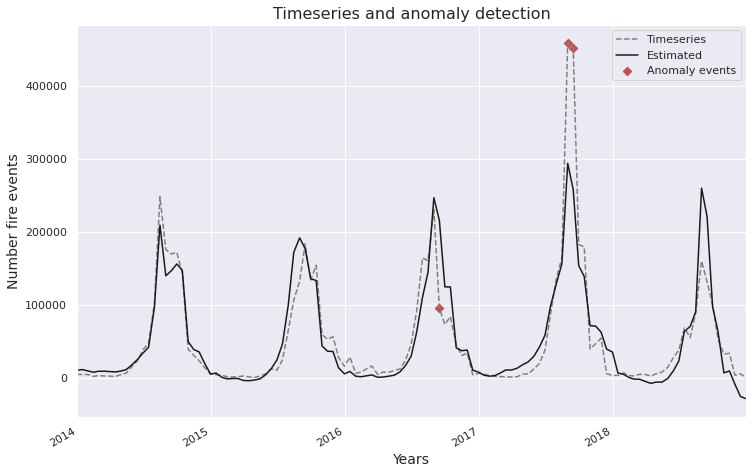

In [550]:
## Plotting the obtained points in the dataset

fig, ax = plt.subplots(figsize = (12,8))

ax.plot(df_all, label = 'Timeseries', c = 'grey', linestyle = '--')
ax.plot(seasonal+trend, label = "Estimated", c = 'k')
ax.scatter(anomaly_dates.index, anomaly_dates.riscofogo, color='r', marker='D', label = 'Anomaly events')

ax.set_xlabel('Years', fontsize = 14)
ax.set_ylabel('Number fire events', fontsize = 14)

ax.set_title('Timeseries and anomaly detection', fontsize = 16)
ax.set_xlim(df_all.index[0], df_all.index[-1])

plt.gcf().autofmt_xdate()
plt.legend()

plt.show()

Understanding it better, if we google it "fire events Brazil 2017" We find a bunch of news
saying that brazil got a record in the number of fire events since 1999! For those interestered
might wanna check [this](https://imazon.org.br/imprensa/brasil-termina-2017-com-numero-recorde-de-queimadas-desde-1999/) or [this one](https://g1.globo.com/natureza/noticia/brasil-tem-ano-com-o-maior-numero-de-queimadas-da-historia.ghtml).

It is also quite sad, because by what we have investigated so far we know that 2019 was
also a record and 2020 broke it again. So, within the near future these events which were
anomaly so far might not be anymore and may be the new reality of our biomes.

Now let's get back and include the fact that these peaks were indeed anomalies and make
a new prediction for 2018. *Okay, but how to do so?* The idea is simple: since we have
already identified the anomalies we are going to built a new dataset where the anomalies
are replaced by the mean value of the regular data (at the same date, of course). We then are going
to use these new data, where the anomaly is corrected, to make a new model for the prediction
in 2018.
<a id='new_dataset'></a>

In [551]:
df_all_ac = df_all.copy() #ac stands for anomaly corrected
y_train_ac = y_train.copy()

# Due to the days which our events fall off, we can simply consider one week interval around these days

for date in anomaly_dates.index:
    condition = (y_train_ac.index.month == date.month) & (y_train_ac.index.day  == date.day) & (y_train_ac.index.year != date.year)
    corrected_value = y_train_ac[condition].mean() # take the mean for by other years
    y_train_ac.loc[date].iat[0] = corrected_value  # change the anomaly event

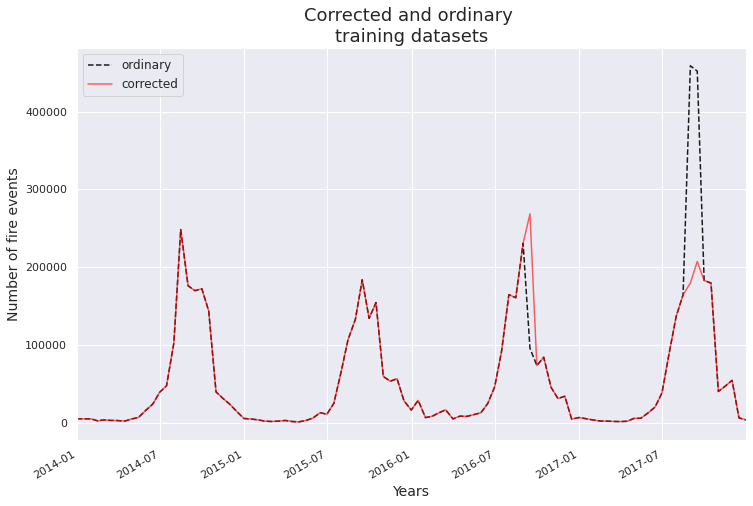

In [552]:
fig, ax = plt.subplots(figsize = (12,8))

ax.plot(y_train, linestyle = '--', color = 'k', label = 'ordinary')
ax.plot(y_train_ac, color = 'red', label = 'corrected', alpha = 0.6)

ax.set_xlabel('Years', fontsize = 14)
ax.set_ylabel('Number of fire events', fontsize = 14)
ax.set_title('Corrected and ordinary \ntraining datasets', fontsize = 18)

plt.gcf().autofmt_xdate()
ax.set_xlim(y_train_ac.index[0], y_train_ac.index[-1])
plt.legend(fontsize = 12)

plt.show()

## Summing up and next steps

Now we have corrected the anomaly effect in a new dataset and we are going to use it to predict
2018 events. For doing so, let's follow similar steps to those ones at the beginning and get the
best model

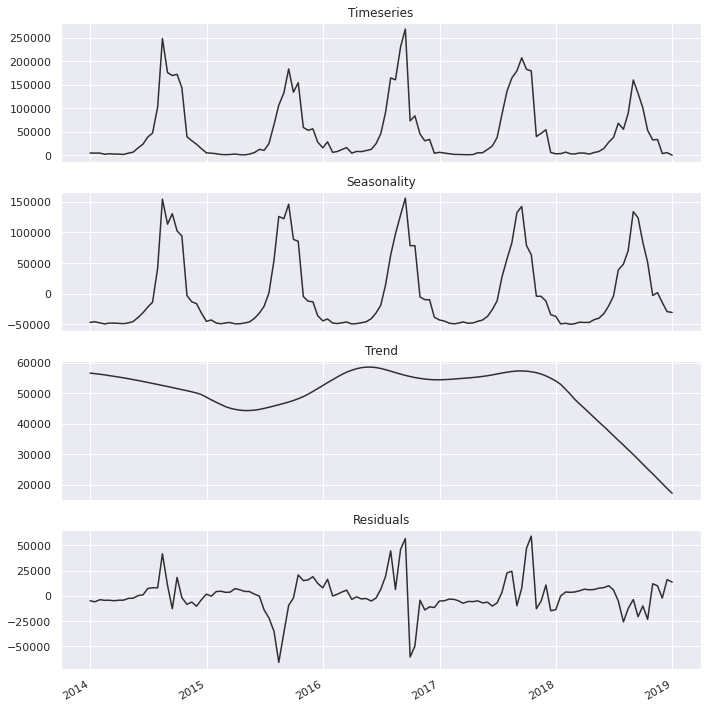

In [553]:
## seasonal trend decomposition 
df_all_ac = pd.concat([y_train_ac, y_test])

stl = STL(df_all_ac, period = 24)
decomposition = stl.fit()

seasonal, trend, residuals = decomposition.seasonal, decomposition.trend, decomposition.resid

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize = (10, 10))

ax1.plot(df_all_ac, c = 'black', alpha = 0.8)
ax1.set_title('Timeseries')
ax2.plot(seasonal, c = 'black', alpha = 0.8)
ax2.set_title('Seasonality')
ax3.plot(trend, c = 'black', alpha = 0.8)
ax3.set_title('Trend')
ax4.plot(residuals, c = 'black', alpha = 0.8)
ax4.set_title('Residuals')
plt.gcf().autofmt_xdate()


plt.tight_layout()
plt.show()

/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


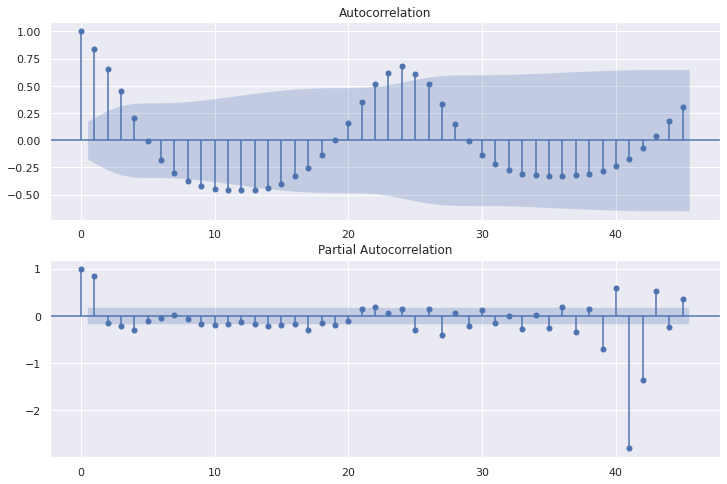

In [365]:
#Investigating the ACF and PACF

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 8))

plot_acf(df_all_ac.dropna(),lags=45,ax=ax1)
plot_pacf(df_all_ac.dropna(),lags=45,ax=ax2)
plt.show()

/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


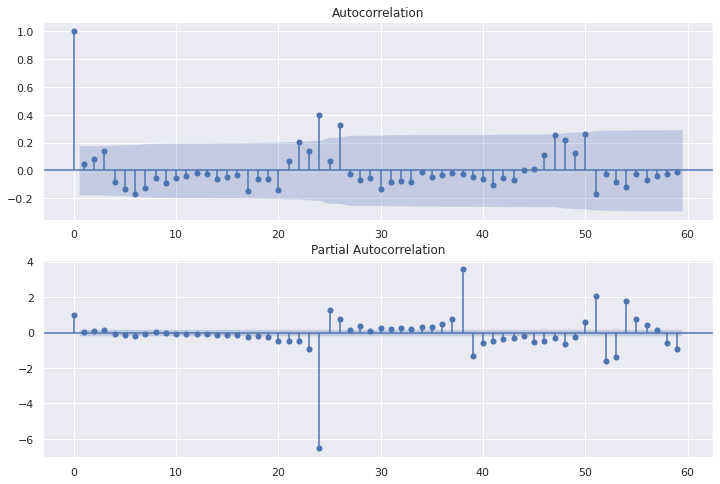

In [368]:
## Same discussion as before, first and seasonal difference

diff_1st_ac = (df_all_ac - df_all_ac.shift(1)).dropna()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 8))

plot_acf(diff_1st_ac.riscofogo.dropna(), lags = 59, ax = ax1)
plot_pacf(diff_1st_ac.riscofogo.dropna(), lags = 59, ax = ax2)

plt.show()

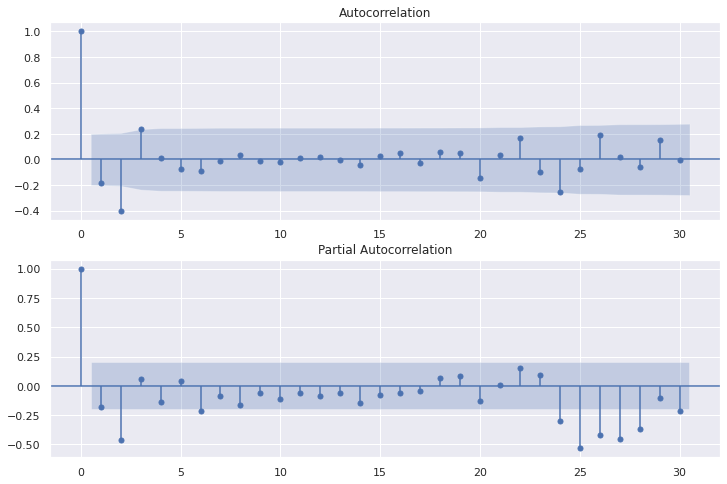

In [374]:
## So the shut off desired behavior has been obtained, lets make the seasonal difference now

diff_full_ac = (diff_1st_ac - diff_1st_ac.shift(24)).dropna()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 8))

plot_acf(diff_full_ac.riscofogo.dropna(), lags = 30, ax = ax1)
plot_pacf(diff_full_ac.riscofogo.dropna(), lags = 30, ax = ax2)

plt.show()

At the start we already have

$$ d = D = 1 $$

by the PACF we conclude that
$$ p = 2\\ P = 1$$
ACF tells us that
$$ q = 3\\ Q = 1$$

Although the model clearly says that and we have a strong shut off on the PACF for these values.
We observe few intereting features : firstly, the sixth lag might be relevant in the PACF and,
regarding the seasonal component, we see a bunch off lags close to the border, which might become
a relevant lag. So it is also worth checking out a possibility of $D = 2$.

In [376]:
dict_model_AC = dict()

for q in range (1, 4):
    for p in range (1, 3):
        #for d in range (0, 2): # Let's try some differences and see how it affects the model
        for Q in range (1, 3):
                for P in range (1, 3):
                    for D in range (1, 3):
                        order = (p, 1, q)
                        sorder = (P, D, Q, 24)
                        model = model_sarima(order, sorder)
                        print('Model : {} X {}; AIC : {}'.format(order, sorder, model[2]))
                        dict_model[model[2]] = (order, sorder)

Model : (1, 1, 1) X (1, 1, 1, 24); AIC : 5718.336073701096


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Model : (1, 1, 1) X (1, 2, 1, 24); AIC : 1172.7510580638195
Model : (1, 1, 1) X (2, 1, 1, 24); AIC : 3994.9293752891062
Model : (1, 1, 1) X (2, 2, 1, 24); AIC : 588.3507674083863
Model : (1, 1, 1) X (1, 1, 2, 24); AIC : 1141.2571898355652
Model : (1, 1, 1) X (1, 2, 2, 24); AIC : 563.3015642212368
Model : (1, 1, 1) X (2, 1, 2, 24); AIC : 1142.1981844115287
Model : (1, 1, 1) X (2, 2, 2, 24); AIC : 565.2903569021497
Model : (2, 1, 1) X (1, 1, 1, 24); AIC : 5719.998899437173
Model : (2, 1, 1) X (1, 2, 1, 24); AIC : 1174.4655134225798
Model : (2, 1, 1) X (2, 1, 1, 24); AIC : 3911.964625432317
Model : (2, 1, 1) X (2, 2, 1, 24); AIC : 565.169427726094
Model : (2, 1, 1) X (1, 1, 2, 24); AIC : 1141.5182672450671
Model : (2, 1, 1) X (1, 2, 2, 24); AIC : 565.2024920591211
Model : (2, 1, 1) X (2, 1, 2, 24); AIC : 1139.8219275884173
Model : (2, 1, 1) X (2, 2, 2, 24); AIC : 567.1694239591687
Model : (1, 1, 2) X (1, 1, 1, 24); AIC : 5639.634275624668
Model : (1, 1, 2) X (1, 2, 1, 24); AIC : 1150.1213

/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 1, 2) X (1, 2, 2, 24); AIC : 542.7863690117358


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 1, 2) X (2, 1, 2, 24); AIC : 1117.376379614818


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 1, 2) X (2, 2, 2, 24); AIC : 544.7627496713257
Model : (1, 1, 3) X (1, 1, 1, 24); AIC : 5561.958510411838
Model : (1, 1, 3) X (1, 2, 1, 24); AIC : 1127.6840505033585
Model : (1, 1, 3) X (2, 1, 1, 24); AIC : 4000.8078222862164
Model : (1, 1, 3) X (2, 2, 1, 24); AIC : 593.5889750194945


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 1, 3) X (1, 1, 2, 24); AIC : 1095.4179922789147


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 1, 3) X (1, 2, 2, 24); AIC : 518.2839860383995


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (1, 1, 3) X (2, 1, 2, 24); AIC : 1094.5687682764517
Model : (1, 1, 3) X (2, 2, 2, 24); AIC : 520.2668085832722
Model : (2, 1, 3) X (1, 1, 1, 24); AIC : 5562.805530991706
Model : (2, 1, 3) X (1, 2, 1, 24); AIC : 1129.446220288604
Model : (2, 1, 3) X (2, 1, 1, 24); AIC : 3917.2447204646314


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 1, 3) X (2, 2, 1, 24); AIC : 570.3607662419339
Model : (2, 1, 3) X (1, 1, 2, 24); AIC : 1098.7451883935798


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 1, 3) X (1, 2, 2, 24); AIC : 520.2257130097097


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 1, 3) X (2, 1, 2, 24); AIC : 1096.359822376258


/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model : (2, 1, 3) X (2, 2, 2, 24); AIC : 522.1977864340182


<a id='new_prediction'></a>
## Prediction using the above method and the new training data

After looping through several models, we plot one of the best SARIMA models having no likelihookd
convergence issues and compare to the dataset and the previous SARIMA model

In [425]:
for score in dict_model:
    if 1000 <= score < 1080:
        print(score, dict_model[score])

1071.9955156479025 ((0, 1, 4), (1, 1, 2, 24))
1069.9629354807932 ((0, 1, 4), (2, 1, 2, 24))
1073.704825062164 ((1, 1, 4), (1, 1, 2, 24))
1074.6891130797012 ((1, 1, 4), (2, 1, 2, 24))
1074.2697662549426 ((2, 1, 4), (1, 1, 2, 24))
1073.3269214529132 ((2, 1, 4), (2, 1, 2, 24))
1073.374853576965 ((3, 1, 4), (1, 1, 2, 24))
1074.7647363999163 ((3, 1, 4), (2, 1, 2, 24))
1074.8260368074802 ((4, 1, 4), (1, 1, 2, 24))
1076.6148971828595 ((4, 1, 4), (2, 1, 2, 24))


In [450]:
y_train_ac = df_all_ac[:len(df_all) - 24]
y_test_ac = df_all_ac[len(df_all) - 24:]

order = (0, 1, 4)
sorder = (2, 1, 2, 24)

sarima_model_ac = sm.tsa.statespace.SARIMAX(y_train_ac.riscofogo, order = order,
                                         seasonal_order = sorder,
                                         enforce_stationarity=False,
                                         enforce_invertibility=False)

## Training the model and getting the prediction
res_ac = sarima_model_ac.fit()
forecast_ac = res_ac.get_forecast(len(y_test))
predictions_ac = forecast_ac.predicted_mean

/home/vhenning/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


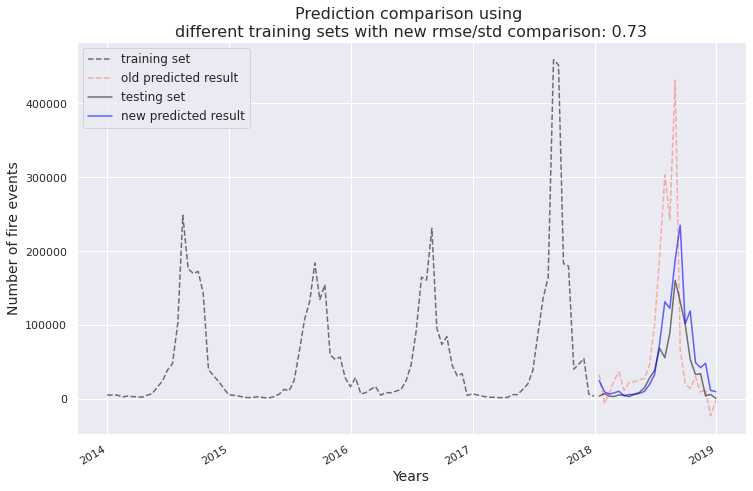

In [457]:
## RMSE and std comparison
rmse_ac = np.sqrt(mean_squared_error(predictions_ac, y_test))
comparison_ac = round(rmse_ac/std, 2)

fig, ax = plt.subplots(figsize = (12, 8))

ax.plot(y_train.riscofogo, label = 'training set', color = 'k', alpha = 0.6, linestyle = '--')
ax.plot(predictions, label = 'old predicted result', color = 'salmon', alpha = 0.6, linestyle = '--')
ax.plot(y_test.riscofogo, label = 'testing set', color = 'k', alpha = 0.6)
ax.plot(predictions_ac, label = 'new predicted result', color = 'blue', alpha = 0.6)

ax.set_title('Prediction comparison using \ndifferent training sets with new rmse/std comparison: {}'.format(comparison_ac),
             fontsize = 16)
ax.set_xlabel('Years', fontsize = 14)
ax.set_ylabel('Number of fire events', fontsize = 14)

plt.gcf().autofmt_xdate()

plt.legend(fontsize = 12)
plt.show()

## Discussion

So handling the anomaly indeed made a **huge** difference. We observe that:
1) There is basically no more shift in the beginning of our prediction

2) The peak is much smaller than the previous prediction and it also captures the small
details of the dataset like the small peaks around the biggest one.

3) Quantitatively, we are able to explain 30\% of the deviation from the mean.

4) Comparing the previous model to the new one (rmse/std), we had an improvement of $2.02/0.73\simeq 2.77$,
which is an improvement of roughly 280\%

<a id='rmse_comparison'></a>

<a id='xgb'></a>

# Implementing XGBoost prediction

In [514]:
import xgboost as xgb
print("xgboost", xgb.__version__)

xgboost 1.3.1


In [554]:
model = xgb.XGBRegressor()

df_all_ac.tail()

,riscofogo
datahora,
2018-10-31,32727.0
2018-11-15,33808.0
2018-11-30,3834.0
2018-12-15,5765.0
2018-12-31,294.0


In [557]:
df_all_xgb = df_all_ac.copy()
df_all_xgb['shift_month'] = df_all_xgb.shift(-2)
df_all_xgb.dropna(inplace = True)

df_all_xgb.tail()

,riscofogo,shift_month
datahora,,
2018-09-30,100734.0,32727.0
2018-10-15,53221.0,33808.0
2018-10-31,32727.0,3834.0
2018-11-15,33808.0,5765.0
2018-11-30,3834.0,294.0


In [561]:
X_train_xgb = df_all_xgb.iloc[:-22, :][['riscofogo']].copy()
y_train_xgb = df_all_xgb.iloc[:-22, :][['shift_month']].copy()
X_test_xgb = df_all_xgb.iloc[-22:, :][['riscofogo']].copy()
y_test_xgb = df_all_xgb.iloc[-22:, :][['shift_month']].copy()

y_test_xgb.head()

,shift_month
datahora,
2018-01-15,3327.0
2018-01-31,2851.0
2018-02-15,5062.0
2018-02-28,4759.0
2018-03-15,2772.0


In [594]:
model = xgb.XGBRegressor(objective = 'reg:squarederror',
                         n_estimators = 100, eta = 0.1)
model.fit(X_train_xgb, y_train_xgb,
          eval_set = [(X_train_xgb, y_train_xgb), (X_test_xgb, y_test_xgb)],
          early_stopping_rounds = 5, verbose = False)

predictions_xgb = model.predict(X_test_xgb)
predictions_xgb = pd.Series(data = predictions_xgb, index = y_test_xgb.index, dtype = 'float64')

<a id='sarima-xgb-comparison'></a>

## Comparing the XGBoost prediction to the SARIMA model prediction

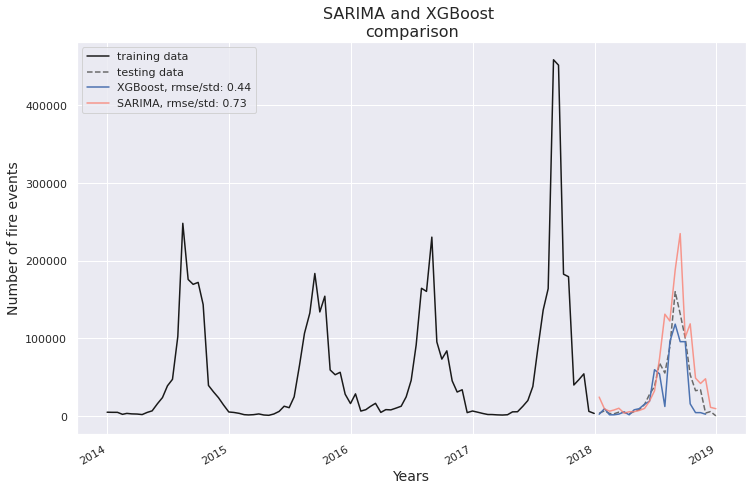

In [602]:
rmse_xgb = round(np.sqrt(mean_squared_error(predictions_xgb, y_test.iloc[:22, :])), 2)
new_std_22 = y_test.iloc[:22, :].riscofogo.std()
comparison_xgb = round(rmse_xgb/new_std_22, 2)

fig, ax = plt.subplots(figsize = (12, 8))

ax.plot(y_train, label = 'training data', color = 'k')
ax.plot(y_test, label = 'testing data', color = 'dimgrey', linestyle = '--')
ax.plot(predictions_xgb, label = 'XGBoost, rmse/std: {}'.format(comparison_xgb))
ax.plot(predictions_ac, label = 'SARIMA, rmse/std: {}'.format(comparison_ac), color = 'salmon', alpha = 0.8)

ax.set_ylabel('Number of fire events', fontsize = 14)
ax.set_xlabel('Years', fontsize = 14)

plt.gcf().autofmt_xdate()

plt.title('SARIMA and XGBoost \ncomparison', fontsize = 16)

plt.legend(loc = 'upper left')

plt.show()

## Discussion of the result

Surprisingly, at least for me, the XGBoost algorithm performed even better than the SARIMA model.
It has the drawback of missing the last points, but it might not be the end of the world for most
situations. When comparing the rmse/std comparison, we observe that whereas the SARIMA model
explains $27\%$ of the deviation from the mean, the XGboost algorithm explains $56\%$ of it,
which corresponds to an improvement of little over a $100\%$


## Improving the XGboost result by feature engineering 
<a id='xgb_feature'></a>
Within this part we are going to explore whether it is possible or not to improve the model's
performance by some feature engineering. The motivation is rather straightforward: depending
on the day of the week, for instance, it might be relevant for when people decides to set fire
on the vegetation or not. Although the data is recorded as semimonth data, it might still be worthy.

In [637]:
df_all_xgb['day_of_week'] = df_all_xgb.index.dayofweek
df_all_xgb['month'] = df_all_xgb.index.month
df_all_xgb['week_of_year'] = df_all_xgb.index.isocalendar().week

df_all_xgb['week_of_year'] = df_all_xgb['week_of_year'].apply(lambda x : round(x))

df_all_xgb.head()

,riscofogo,shift_month,day_of_week,month,week_of_year
datahora,,,,,
2013-12-31,4962.0,4806.0,1,12,1
2014-01-15,4822.0,2223.0,2,1,3
2014-01-31,4806.0,3436.0,4,1,5
2014-02-15,2223.0,2806.0,5,2,7
2014-02-28,3436.0,2594.0,4,2,9


In [638]:
X_train_xgb2 = df_all_xgb.iloc[:-22, :].drop(columns = 'shift_month').copy()
y_train_xgb2 = df_all_xgb.iloc[:-22, :][['shift_month']].copy()
X_test_xgb2= df_all_xgb.iloc[-22:, :].drop(columns = 'shift_month').copy()
y_test_xgb2 = df_all_xgb.iloc[-22:, :][['shift_month']].copy()

X_train_xgb2.head()

,riscofogo,day_of_week,month,week_of_year
datahora,,,,
2013-12-31,4962.0,1,12,1
2014-01-15,4822.0,2,1,3
2014-01-31,4806.0,4,1,5
2014-02-15,2223.0,5,2,7
2014-02-28,3436.0,4,2,9


In [640]:
model = xgb.XGBRegressor(objective = 'reg:squarederror',
                         n_estimators = 1000, eta = 0.1)
model.fit(X_train_xgb2, y_train_xgb2,
          eval_set = [(X_train_xgb2, y_train_xgb2), (X_test_xgb2, y_test_xgb2)],
          early_stopping_rounds = 50, verbose = False)

predictions_xgb2 = model.predict(X_test_xgb2)
predictions_xgb2 = pd.Series(data = predictions_xgb2, index = y_test_xgb2.index, dtype = 'float64')

## Feature importance

So number the past events indeed was the most relevant parameter, as expected. Although
the other 3 features added didn't help that much, for daily data, for instance, it might
be incredibly helpful

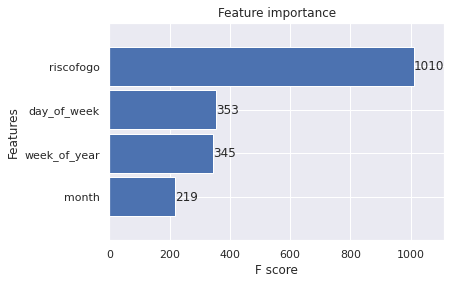

In [644]:
_ = xgb.plot_importance(model, height=0.9)

Let's see how the model performs, i.e., if the inclusion of features improves the model's performance in any way

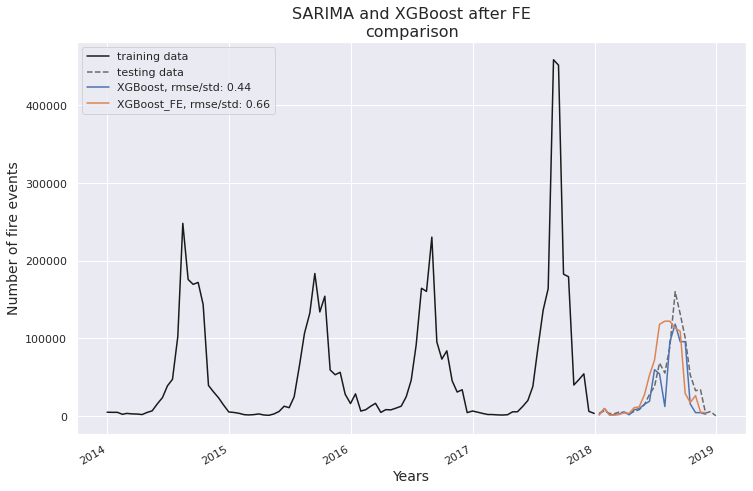

In [645]:
rmse_xgb2 = round(np.sqrt(mean_squared_error(predictions_xgb2, y_test.iloc[:22, :])), 2)
new_std_222 = y_test.iloc[:22, :].riscofogo.std()
comparison_xgb2 = round(rmse_xgb2/new_std_222, 2)

fig, ax = plt.subplots(figsize = (12, 8))

ax.plot(y_train, label = 'training data', color = 'k')
ax.plot(y_test, label = 'testing data', color = 'dimgrey', linestyle = '--')
ax.plot(predictions_xgb, label = 'XGBoost, rmse/std: {}'.format(comparison_xgb))
ax.plot(predictions_xgb2, label = 'XGBoost_FE, rmse/std: {}'.format(comparison_xgb2))

ax.set_ylabel('Number of fire events', fontsize = 14)
ax.set_xlabel('Years', fontsize = 14)

plt.gcf().autofmt_xdate()

plt.title('SARIMA and XGBoost after FE\ncomparison', fontsize = 16)

plt.legend(loc = 'upper left')

plt.show()

Okay, so for this problem the feature engineering didn't help in any way. It actually makes the model performance
worser (compared to the previous XGBoost model).